In [1]:
# Playgroud Series - Binary Classification of Insurance Cross Selling
  # https://www.kaggle.com/competitions/playground-series-s4e7
  # Your Goal: predict which customers respond positively to an automobile insurance offer.
  # Metric: Submissions are evaluated using area under the ROC curve.

# Imports

In [339]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_colwidth', 100)

from sklearn.model_selection       import train_test_split, GridSearchCV#, cross_val_score
#from sklearn.preprocessing         import OneHotEncoder #MinMaxScaler 
from sklearn.metrics               import roc_auc_score

from sklearn.tree                  import DecisionTreeClassifier, plot_tree
# from sklearn.ensemble              import RandomForestClassifier


# #import sweetviz as sv
# from yellowbrick.features import ParallelCoordinates

# Load Data

In [35]:
#Load .csv w/ Pandas
df = pd.read_csv( '..\\data\\kaggle\\train.csv')
df.shape #11M rows!

(11504798, 12)

In [36]:
df.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.00,0,1-2 Year,Yes,65101.00,124.00,187,0
1,1,Male,43,1,28.00,0,> 2 Years,Yes,58911.00,26.00,288,1


In [37]:
df.Response.value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

In [38]:
df.Response.value_counts(normalize=True)*100

Response
0   87.70
1   12.30
Name: proportion, dtype: float64

In [39]:
# Chellenge Metric: ROC Curve -
# It's a binnary classification problem, unbalanced.
# Submitted the sample submission, with all rows = 0.5. It gets 0.5% of the answers right on public leaderboard.

# Data Cleaning

## Rename Cols

In [40]:
#convert all cols to lower case, and replace spaces and dots with underscores
df.columns = df.columns.str.replace(' ','_').str.replace('.','_').str.lower()

In [41]:
df.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## Feature Meanings

In [64]:
#Double check understanding of each column

tab_meanings = [['Column', 'Meaning'],
    #####################################################  
        ['id', 'unique customer identifier.'],
        ['gender', 'client gender: Male / Female.'],
        ['age', 'customer age.'],
        ['driving_license', '0 = customer does not have DL, 1 = already have DL'],       
        ['region_code', 'customer region code.'],
        ['prev_insured', 'vehicle_prev_insured: 0 = customer does not have vehicle insurance, 1= already has vehicle insurance.'],
        ['vehicle_age', 'vehicle age: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = customer has never had their vehicle damaged in the past, Yes = has had it.'],
        ['annual_premium', 'health_annual_paid: annual amount paid by the customer to the company for health insurance. Currency: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],        
        ['policy_sales_channel', 'Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..'],       
        ['vintage', 'days_associated: number of days since the customer joined the company by purchasing health insurance. The policy is annual.'],
        ['response', '0 = customer is not interested, 1 = customer is interested.']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='rst'))

====================  =============================================================================================================================================
Column                Meaning
====================  =============================================================================================================================================
id                    unique customer identifier.
gender                client gender: Male / Female.
age                   customer age.
driving_license       0 = customer does not have DL, 1 = already have DL
region_code           customer region code.
prev_insured          vehicle_prev_insured: 0 = customer does not have vehicle insurance, 1= already has vehicle insurance.
vehicle_age           vehicle age: < 1 Year, 1-2 Year, > 2 Years
vehicle_damage        No = customer has never had their vehicle damaged in the past, Yes = has had it.
annual_premium        health_annual_paid: annual amount paid by the customer to the company for

## Missings

In [44]:
df.isna().sum() #ok!

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## Data Types

In [46]:
df.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [54]:
#check floats that are integers:

df.region_code.nunique #int
df.annual_premium.nunique #int
df.policy_sales_channel.nunique #int

#parse to int
df.region_code = df.region_code.astype(int)
df.annual_premium = df.annual_premium.astype(int)
df.policy_sales_channel = df.policy_sales_channel.astype(int)

In [57]:
#convert to int (binary)
df.vehicle_damage.value_counts()

vehicle_damage
Yes    5783229
No     5721569
Name: count, dtype: int64

In [61]:
vei_dam_dict = {'Yes':1, 'No':0}
df.vehicle_damage = df.vehicle_damage.map(vei_dam_dict)

In [62]:
df.vehicle_damage.value_counts() #ok

vehicle_damage
1    5783229
0    5721569
Name: count, dtype: int64

In [63]:
df.dtypes

id                       int64
gender                  object
age                      int64
driving_license          int64
region_code              int64
previously_insured       int64
vehicle_age             object
vehicle_damage           int64
annual_premium           int64
policy_sales_channel     int64
vintage                  int64
response                 int64
dtype: object

# Descriptive Statistical

In [69]:
#separate cathegorical and numerical attributes
num_attributes = df[['age','annual_premium','vintage']]
cat_attributes = df[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'policy_sales_channel', 'response']]

## Num Attributes

In [74]:
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply ( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply ( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply ( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply ( lambda x: x.kurtosis() ) ).T

#Concatenate
nm = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
nm.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [75]:
nm

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.00,85.00,65.00,38.38,36.00,14.99,0.64,-0.62
1,annual_premium,2630.00,540165.00,537535.00,30461.37,31824.00,16454.74,0.78,24.60
2,vintage,10.00,299.00,289.00,163.90,166.00,79.98,-0.11,-1.11


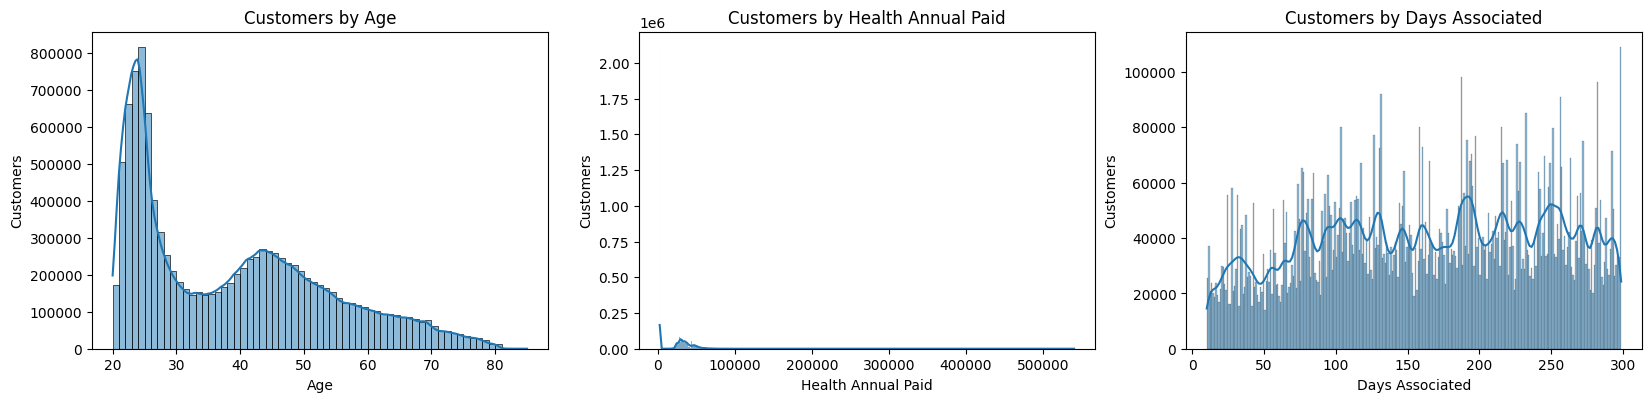

In [79]:
#Num Attributes plot
plt.figure(figsize=(20,14))

plt.subplot(3,3,1)
age_hist = sns.histplot(df['age'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(3,3,2)
hap_hist = sns.histplot(df['annual_premium'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('Health Annual Paid')
hap_hist.set_title('Customers by Health Annual Paid');

plt.subplot(3,3,3)
da_hist = sns.histplot(df['vintage'], binwidth=1, kde=True);
da_hist.set_ylabel('Customers')
da_hist.set_xlabel('Days Associated')
da_hist.set_title('Customers by Days Associated');

In [ ]:
#Highlights:

#age: there is a peak at 25y/old
#health_annual_premium: very big range of 537535, high kurtosis, some extreme values.

## Cat Attributes

In [81]:
#variations of each column
print(f"- Distinct values:\n{cat_attributes.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{cat_attributes.apply( lambda x: x.unique() ) } " )

- Distinct values:
gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    152
response                  2
dtype: int64 

- Variations:
gender                                                     [Male, Female]
driving_license                                                    [1, 0]
region_code             [35, 28, 14, 1, 15, 47, 45, 8, 11, 3, 10, 12, ...
previously_insured                                                 [0, 1]
vehicle_age                               [1-2 Year, > 2 Years, < 1 Year]
vehicle_damage                                                     [1, 0]
policy_sales_channel    [124, 26, 152, 156, 160, 8, 31, 157, 60, 122, ...
response                                                           [0, 1]
dtype: object 


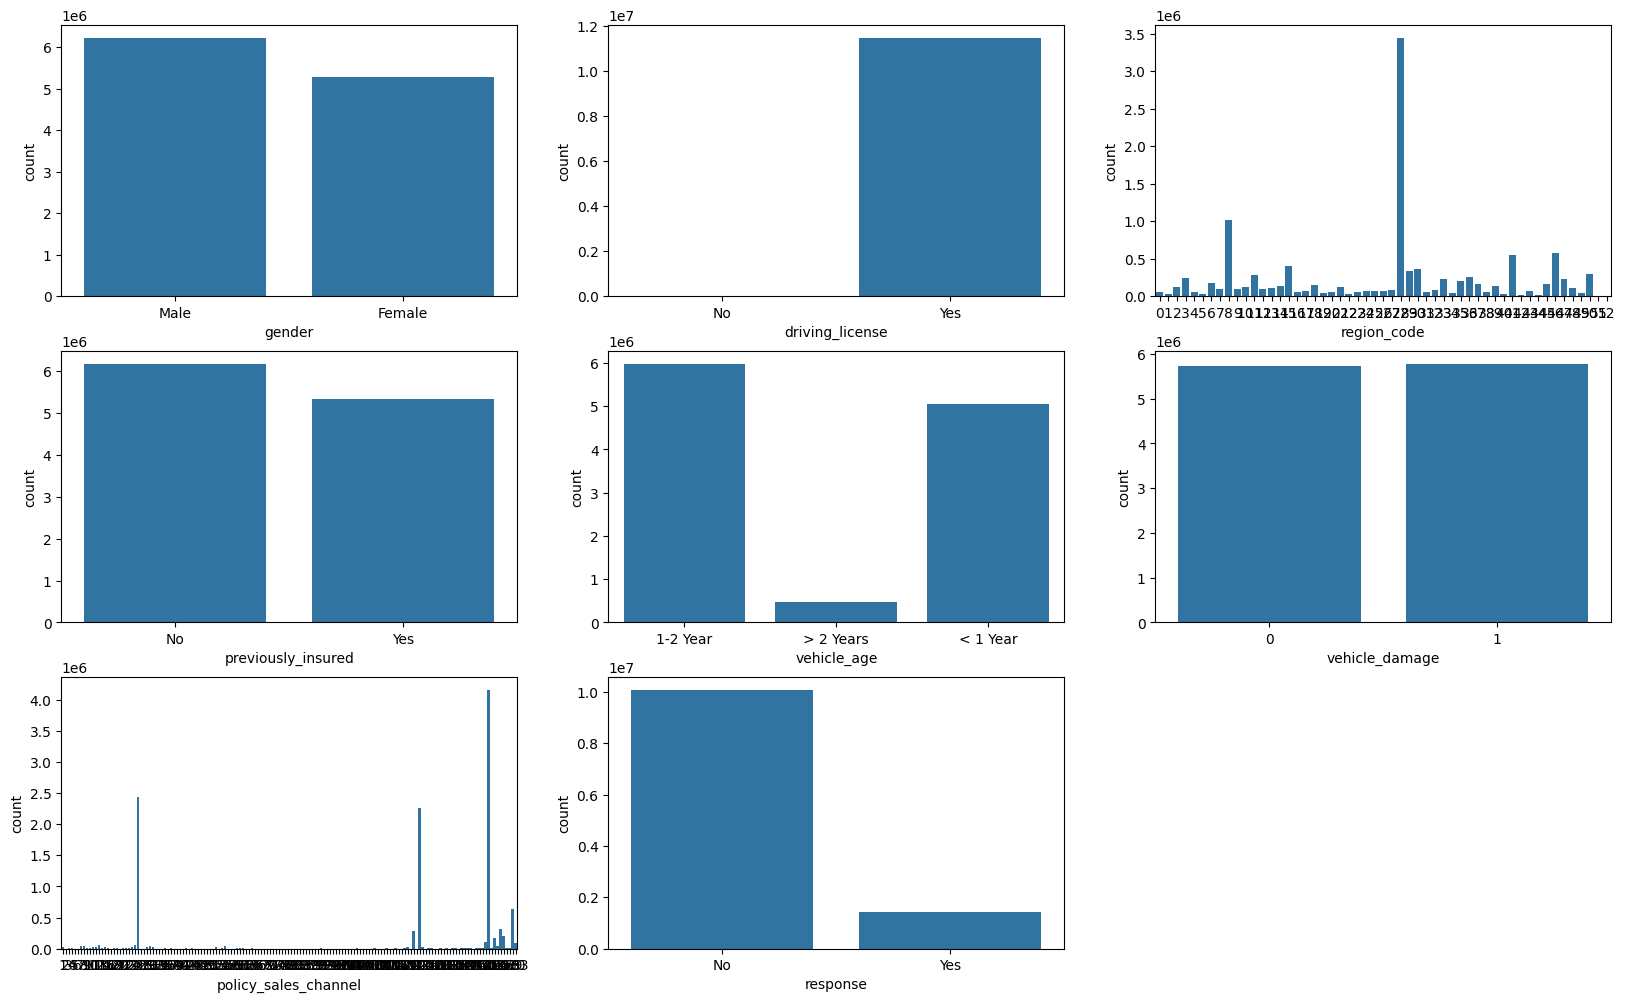

In [83]:
plt.figure(figsize=(20,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes['gender']);

plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['region_code']);

plt.subplot (3,3,4)
sns.countplot (x = cat_attributes['previously_insured']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,5)
sns.countplot (x = cat_attributes['vehicle_age']);

plt.subplot (3,3,6)
sns.countplot (x = cat_attributes['vehicle_damage']);

plt.subplot (3,3,7)
sns.countplot (x = cat_attributes['policy_sales_channel']);

plt.subplot (3,3,8)
sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['No','Yes']);


In [ ]:
#Highlights:
#region_code and policy_sales_channel: many variations, few with many customers
#driving_license: less than 1% has not.

In [91]:
df.driving_license.value_counts()

driving_license
1    11482041
0       22757
Name: count, dtype: int64

In [89]:
df.driving_license.value_counts(normalize=True)

driving_license
1   1.00
0   0.00
Name: proportion, dtype: float64

# Checkpoint 1

In [95]:
#df.to_parquet('..\\data\\v1\\chp1.parquet')

In [131]:
df = pd.read_parquet( '..\\data\\v1\\chp1.parquet')
print(df.shape)
df[:3]

(11504798, 12)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,0,Male,21,1,35,0,1-2 Year,1,65101,124,187,0
1,1,Male,43,1,28,0,> 2 Years,1,58911,26,288,1
2,2,Female,25,1,14,1,< 1 Year,0,38043,152,254,0


# Dataset Split

In [137]:
#start with 50k, to test CV methods
df50k = df.sample(50000).reset_index(drop=True).copy()

In [193]:
print(df50k.shape)
df50k[:2]

(50000, 12)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7333901,Female,68,1,28,0,1-2 Year,1,55409,26,31,1
1,7657835,Female,22,1,46,1,< 1 Year,0,43985,152,126,0


In [205]:
X = df50k.drop(columns="response") 
y = df50k.response

In [206]:
#split between train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 98, stratify = y, test_size = 0.20) #stratify by y

In [207]:
# train data
print('X_train -> ',X_train.shape)
print('y_train -> ',y_train.shape)
# test data
print('X_test -> ',X_test.shape)
print('y_test -> ',y_test.shape)

X_train ->  (40000, 11)
y_train ->  (40000,)
X_test ->  (10000, 11)
y_test ->  (10000,)


In [208]:
#destroy df
df=''

# EDA (jump)

# Data Prep (jump)

In [209]:
X_train[:2]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
18457,1284966,Female,45,1,28,0,1-2 Year,1,34904,124,268
37272,10492266,Female,36,1,28,0,1-2 Year,1,35461,125,252


In [210]:
#Encode cat variables with OHE

### train

#### vehicle_age

In [211]:
#Change variations, removing spaces
dict_vehicle_age = { '> 2 Years':'over_2_y', '1-2 Year':'bet_1-2_y', '< 1 Year': 'below_1_y' }
X_train['vehicle_age'] = X_train['vehicle_age'].map(dict_vehicle_age)
X_train['vehicle_age'].value_counts()

vehicle_age
bet_1-2_y    20716
below_1_y    17610
over_2_y      1674
Name: count, dtype: int64

In [212]:
#OHE on vehicle age:
X_train = pd.get_dummies( X_train, prefix='vehicle_age', columns=['vehicle_age'], dtype=int)

In [213]:
X_train[:2]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_y,vehicle_age_bet_1-2_y,vehicle_age_over_2_y
18457,1284966,Female,45,1,28,0,1,34904,124,268,0,1,0
37272,10492266,Female,36,1,28,0,1,35461,125,252,0,1,0


#### gender

In [214]:
#Keep just 1 column
dict_gender = {'Male': 1, 'Female':0}
X_train['gender'] = X_train['gender'].map(dict_gender)
X_train['gender'].value_counts()

gender
1    21711
0    18289
Name: count, dtype: int64

In [215]:
#Gender now means: is_male? (0 / 1)
X_train.rename(columns={'gender':'is_male'}, inplace=True)

In [216]:
X_train[:2]

,id,is_male,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_y,vehicle_age_bet_1-2_y,vehicle_age_over_2_y
18457,1284966,0,45,1,28,0,1,34904,124,268,0,1,0
37272,10492266,0,36,1,28,0,1,35461,125,252,0,1,0


### test

#### vehicle_age

In [ ]:
#Replicate transformations:

In [332]:
#Change variations, removing spaces
dict_vehicle_age = { '> 2 Years':'over_2_y', '1-2 Year':'bet_1-2_y', '< 1 Year': 'below_1_y' }
X_test['vehicle_age'] = X_test['vehicle_age'].map(dict_vehicle_age)
X_test['vehicle_age'].value_counts()

vehicle_age
bet_1-2_y    5212
below_1_y    4364
over_2_y      424
Name: count, dtype: int64

In [333]:
#OHE on vehicle age:
X_test = pd.get_dummies( X_test, prefix='vehicle_age', columns=['vehicle_age'], dtype=int)

In [334]:
X_test[:2]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_y,vehicle_age_bet_1-2_y,vehicle_age_over_2_y
33859,1987189,Male,39,1,29,0,1,2630,155,117,0,1,0
3076,7589504,Female,21,1,8,1,0,73824,160,113,1,0,0


#### gender

In [335]:
#Keep just 1 column
dict_gender = {'Male': 1, 'Female':0}
X_test['gender'] = X_test['gender'].map(dict_gender)
X_test['gender'].value_counts()

gender
1    5342
0    4658
Name: count, dtype: int64

In [336]:
#Gender now means: is_male? (0 / 1)
X_test.rename(columns={'gender':'is_male'}, inplace=True)

In [337]:
X_test[:2]

,id,is_male,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_y,vehicle_age_bet_1-2_y,vehicle_age_over_2_y
33859,1987189,1,39,1,29,0,1,2630,155,117,0,1,0
3076,7589504,0,21,1,8,1,0,73824,160,113,1,0,0


# ML

## Decision Tree

In [306]:
# GridSearch + Cross Validation

# dictionary of possible hiperparameters to test their combinations
param_grid = {'max_depth': [3, 4, 5], 'class_weight': [None, 'balanced'] }#, 'max_leaf_nodes': [10, 40, 100]  ,  'min_samples_leaf':[10, 20]}
# -> max_leaf_nodes and min_samples_leaf did not improve the model's performance
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'max_depth': [3, 4, 5], 'class_weight': [None, 'balanced']}


In [310]:
# instantiate a DT Classifier, on a GridSearchCV, and the number of K folds:
grid_src_DTClassif = GridSearchCV(DecisionTreeClassifier(random_state=98), param_grid, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True) #return_train_score=True 
    # GridSearchCV: will run CV for each combination of parameters (can be costly) 
    # Just like cross_val_score, GridSearchCV will use stratified k-fold cross-validation by default for classification, and k-fold for regression.
     #'refit'=True(default): will retrain a final model with all data (TRAIN and VAL), with the best CV parameters found against VAL.
     # this model will be in the GridSearchCV object, and its score is obtained by calling the 'score' method.

grid_src_DTClassif.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=98),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 4, 5]},
             return_train_score=True, scoring='roc_auc')

In [311]:
# Get best parameters, and also the best score with cross-validation (VAL DATA):
print("Best parameters (val): {}".format(grid_src_DTClassif.best_params_))
print("Best cross-validation score (val): {:.3f}".format(grid_src_DTClassif.best_score_))

Best parameters (val): {'class_weight': 'balanced', 'max_depth': 5}
Best cross-validation score (val): 0.840


In [321]:
# Melhor modelo encontrado EM VAL:
best_estimator = grid_src_DTClassif.best_estimator_
print("Best estimator (val): {}".format(best_estimator))

Best estimator (val): DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=98)


In [315]:
# Ranking of best models with CV, considering all given combinations of parameters. (mean_test_score = VAL):
pd.DataFrame(grid_src_DTClassif.cv_results_)[['rank_test_score','params','mean_train_score','mean_test_score']].sort_values('rank_test_score')[:5]

,rank_test_score,params,mean_train_score,mean_test_score
5,1,"{'class_weight': 'balanced', 'max_depth': 5}",0.844,0.840
2,2,"{'class_weight': None, 'max_depth': 5}",0.846,0.840
1,3,"{'class_weight': None, 'max_depth': 4}",0.839,0.837
4,4,"{'class_weight': 'balanced', 'max_depth': 4}",0.839,0.836
0,5,"{'class_weight': None, 'max_depth': 3}",0.831,0.829


In [328]:
best_estimator

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=98)

In [ ]:
#Since target is not balanced, 'class_weight': 'balanced' was tried, but dint improve the model.

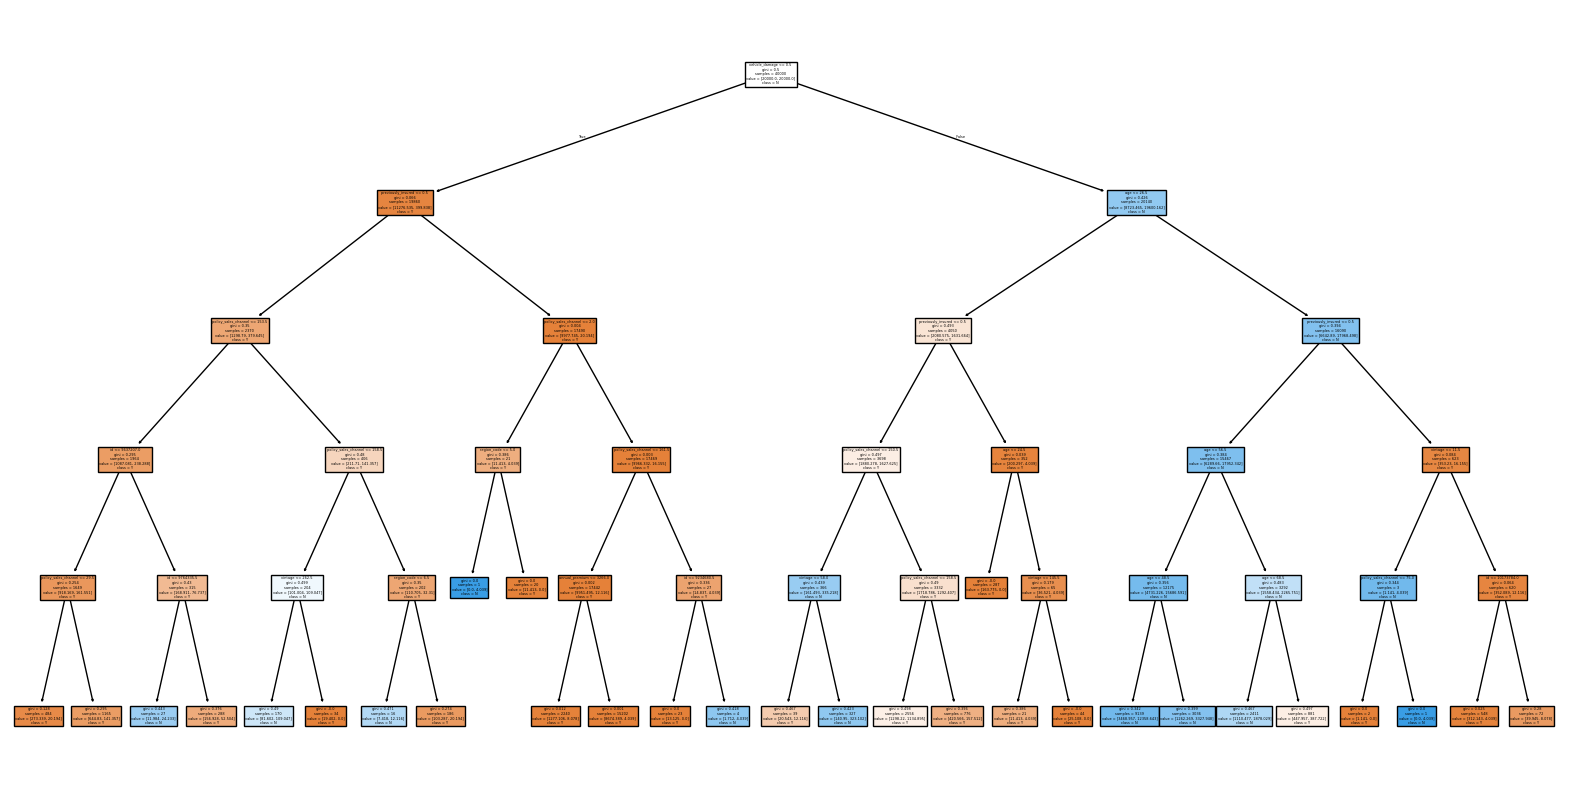

In [330]:
# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(best_estimator, filled=True, feature_names=X_train.columns, class_names=['Y','N'])
plt.show()

In [ ]:
#Too big to inspect.

In [ ]:
# Try other models....

In [340]:
#Final evaluation - predict w/ test data (splitted on train_test_split), simulating production data:

# Predict probabilities
y_pred_prob = best_estimator.predict_proba(X_test)[:, 1]
y_pred_prob[:4]

array([7.80828622e-01, 4.65380611e-04, 4.65380611e-04, 4.65380611e-04])

In [341]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("Best Estimator (TEST) ROC AUC Score: {:.3f}".format(roc_auc))

Best Estimator (TEST) ROC AUC Score: 0.836


In [ ]:
# The performance is pretty similar to the val one. Let's submit!

# Kaggle Test Prediction

In [364]:
# Load .csv w/ Pandas (production data, to submit predictions)
X_prod = pd.read_csv('..\\data\\kaggle\\test.csv')
print(X_prod.shape) #7 MI rows!
X_prod[:3]

(7669866, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.000,0,< 1 Year,No,2630.000,160.000,228
1,11504799,Male,47,1,28.000,0,1-2 Year,Yes,37483.000,124.000,123
2,11504800,Male,47,1,43.000,0,1-2 Year,Yes,2630.000,26.000,271


## Transform data

In [365]:
#Reply all transformations done to train data:


#convert all cols to lower case, and replace spaces and dots with underscores
X_prod.columns = X_prod.columns.str.replace(' ','_').str.replace('.','_').str.lower();

#data types:
#parse to int
X_prod.region_code = X_prod.region_code.astype(int)
X_prod.annual_premium = X_prod.annual_premium.astype(int)
X_prod.policy_sales_channel = X_prod.policy_sales_channel.astype(int)

#convert to int (binary)
vei_dam_dict = {'Yes':1, 'No':0}
X_prod.vehicle_damage = X_prod.vehicle_damage.map(vei_dam_dict)

#data prep:
#vehicle_age
#Change variations, removing spaces
dict_vehicle_age = { '> 2 Years':'over_2_y', '1-2 Year':'bet_1-2_y', '< 1 Year': 'below_1_y' }
X_prod['vehicle_age'] = X_prod['vehicle_age'].map(dict_vehicle_age)
#OHE on vehicle age:
X_prod = pd.get_dummies( X_prod, prefix='vehicle_age', columns=['vehicle_age'], dtype=int)

#gender
#Keep just 1 column
dict_gender = {'Male': 1, 'Female':0}
X_prod['gender'] = X_prod['gender'].map(dict_gender)
X_prod['gender'].value_counts()
#Gender now means: is_male? (0 / 1)
X_prod.rename(columns={'gender':'is_male'}, inplace=True)

In [366]:
#same format a X_train before training
X_prod.head(3)

,id,is_male,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_y,vehicle_age_bet_1-2_y,vehicle_age_over_2_y
0,11504798,0,20,1,47,0,0,2630,160,228,1,0,0
1,11504799,1,47,1,28,0,1,37483,124,123,0,1,0
2,11504800,1,47,1,43,0,1,2630,26,271,0,1,0


In [367]:
#predict on test data:
y_hat_prod = best_estimator.predict(X_prod)

In [369]:
#Predictions done:
print(y_hat_prod.shape)
y_hat_prod[:5]

(7669866,)


array([0, 1, 1, 0, 0])

In [373]:
# Prepare for submission: id + predictions:

#Samples Submission format: 
#id,Response
#11504798,0.5

# Create final dataset
df_sub = pd.concat([X_prod['id'], pd.Series(y_hat_prod, name='Target')], axis=1)
#File to be submitted:
df_sub[:3]

,id,Target
0,11504798,0
1,11504799,1
2,11504800,1


In [374]:
# Export to submit on Kaggle
df_sub.to_csv('..\\data\\v1\\submission_v1.csv', index=False)

# Improvements (to do)

In [ ]:
# use mode data (used 50k on train).
# Change threshold of classification
# Test other models (ensemble, linear..)
# Plot ROC_AUC curve to compare moodels

#### gender

In [214]:
#Keep just 1 column
dict_gender = {'Male': 1, 'Female':0}
X_train['gender'] = X_train['gender'].map(dict_gender)
X_train['gender'].value_counts()

gender
1    21711
0    18289
Name: count, dtype: int64

In [215]:
#Gender now means: is_male? (0 / 1)
X_train.rename(columns={'gender':'is_male'}, inplace=True)

In [216]:
X_train[:2]

,id,is_male,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_y,vehicle_age_bet_1-2_y,vehicle_age_over_2_y
18457,1284966,0,45,1,28,0,1,34904,124,268,0,1,0
37272,10492266,0,36,1,28,0,1,35461,125,252,0,1,0
